In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.7/site-packages/')
sys.path.append('..')

In [3]:
from typing import Callable, Optional

import logging

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Custom code
from coordination.common.sparse_series import SparseSeries
from coordination.component.speech.vocalics_component import VocalicsComponent
from coordination.entity.trial import Trial
from coordination.inference.vocalics import DiscreteCoordinationInferenceFromVocalics, ContinuousCoordinationInferenceFromVocalics
from coordination.plot.coordination import add_discrete_coordination_bar
from coordination.plot.vocalics import plot_vocalic_features

In [31]:
# Constants
NUM_TIME_STEPS = 100
M = int(NUM_TIME_STEPS/2) # We assume coordination in the second half of the period is constant
NUM_FEATURES = 1 

# Common parameters
MEAN_PRIOR_A = np.zeros(NUM_FEATURES)
MEAN_PRIOR_B = np.zeros(NUM_FEATURES)
STD_PRIOR_A = np.ones(NUM_FEATURES)
STD_PRIOR_B = np.ones(NUM_FEATURES)
ANTIPHASE_FUNCTION = lambda x, s: -x if s == 0 else x
ANYPHASE_FUNCTION = lambda x, s: np.abs(x)

# Parameters of the discrete model
P_COORDINATION_TRANSITION = 0.1 # Coordination changes with small probability
P_COORDINATION = 0.5 # The process starts with unknown coordination
STD_UNCOORDINATED_A = np.ones(NUM_FEATURES)
STD_UNCOORDINATED_B = np.ones(NUM_FEATURES)
STD_COORDINATED_A = np.ones(NUM_FEATURES)
STD_COORDINATED_B = np.ones(NUM_FEATURES)

# Parameters of the continuous model
MEAN_COORDINATION_PRIOR = 0.5; STD_COORDINATION_PRIOR = 0 # The process starts with unknown coordination
STD_COORDINATION_DRIFT = 0.1 # Coordination drifts by a little
STD_COUPLING_A = np.ones(NUM_FEATURES)
STD_COUPLING_B = np.ones(NUM_FEATURES)

In [19]:
def get_discrete_inference_engine(series_a: SparseSeries, series_b: SparseSeries, f: Optional[Callable] = lambda x, s : x):
    return DiscreteCoordinationInferenceFromVocalics(series_a=series_a, 
                                                     series_b=series_b, 
                                                     p_prior_coordination=P_COORDINATION, 
                                                     p_coordination_transition=P_COORDINATION_TRANSITION, 
                                                     mean_prior_a=MEAN_PRIOR_A,
                                                     mean_prior_b=MEAN_PRIOR_B,
                                                     std_prior_a=STD_PRIOR_A,
                                                     std_prior_b=STD_PRIOR_B,
                                                     std_uncoordinated_a=STD_UNCOORDINATED_A,
                                                     std_uncoordinated_b=STD_UNCOORDINATED_B,
                                                     std_coordinated_a=STD_COORDINATED_A,
                                                     std_coordinated_b=STD_COORDINATED_B,
                                                     f=f)

def get_continuous_inference_engine(series_a: SparseSeries, series_b: SparseSeries, f: Optional[Callable] = lambda x, s : x):
    return ContinuousCoordinationInferenceFromVocalics(series_a=series_a, 
                                                       series_b=series_b, 
                                                       mean_prior_coordination=MEAN_COORDINATION_PRIOR, 
                                                       std_prior_coordination=STD_COORDINATION_PRIOR, 
                                                       std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                       mean_prior_a=MEAN_PRIOR_A,
                                                       mean_prior_b=MEAN_PRIOR_B,
                                                       std_prior_a=STD_PRIOR_A,
                                                       std_prior_b=STD_PRIOR_B,
                                                       std_coupling_a=STD_COUPLING_A,
                                                       std_coupling_b=STD_COUPLING_B,
                                                       f=f)

### Perfect Alignment

For the series of toy vocalics below, both phase, any-phase do not change the alignment and should result in the same coordination estimates over time.

Text(0.5, 1.0, 'Toy Feature')

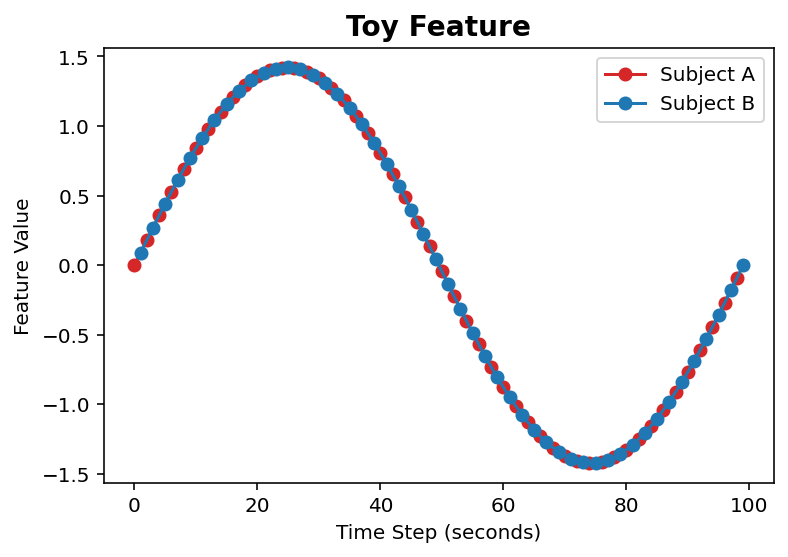

In [82]:
xs = np.sin(np.linspace(0,2*np.pi,NUM_TIME_STEPS))
mask_a = np.array([1 if i % 2 == 0 else 0 for i in range(NUM_TIME_STEPS)])
mask_b = 1 - mask_a
series_a = SparseSeries(xs, mask_a)
series_b = SparseSeries(xs, mask_b)
series_a.normalize()
series_b.normalize()

fig = plt.figure(figsize=(6,4))
plot_vocalic_features([fig.gca()], series_a, series_b, feature_names=[""])
plt.ylabel("Feature Value")
plt.title("Toy Feature", fontsize=14, weight="bold")

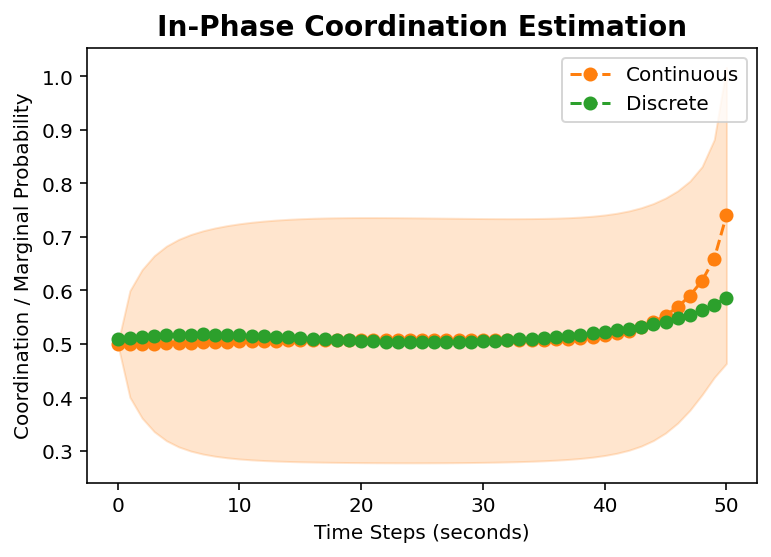

In [79]:
discrete_inference_engine = get_discrete_inference_engine(series_a, series_b)
continuous_inference_engine = get_continuous_inference_engine(series_a, series_b)

marginal_cs = discrete_inference_engine.estimate_marginals()[1]
params = continuous_inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(6, 4))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--", label="Continuous")
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:green", linestyle="--", label="Discrete")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination / Marginal Probability")
plt.title("In-Phase Coordination Estimation", fontsize=14, weight="bold")
plt.legend()

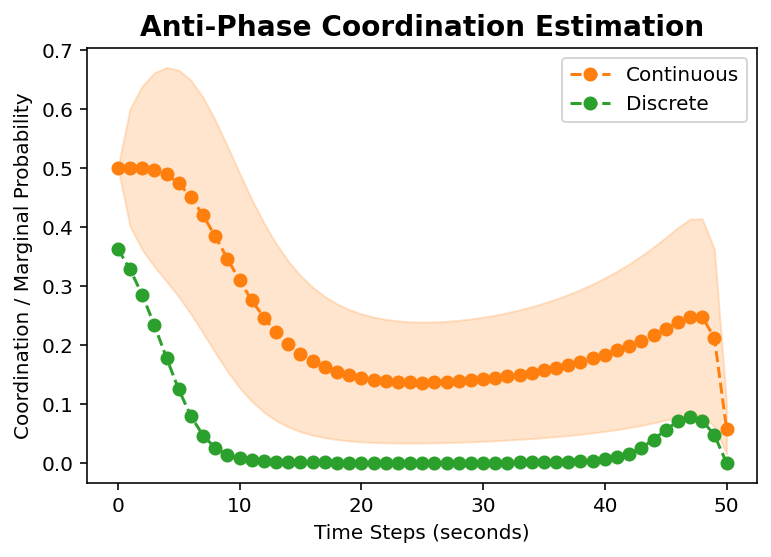

In [80]:
discrete_inference_engine = get_discrete_inference_engine(series_a, series_b, ANTIPHASE_FUNCTION)
continuous_inference_engine = get_continuous_inference_engine(series_a, series_b, ANTIPHASE_FUNCTION)

marginal_cs = discrete_inference_engine.estimate_marginals()[1]
params = continuous_inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(6, 4))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--", label="Continuous")
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:green", linestyle="--", label="Discrete")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination / Marginal Probability")
plt.title("Anti-Phase Coordination Estimation", fontsize=14, weight="bold")
plt.legend()

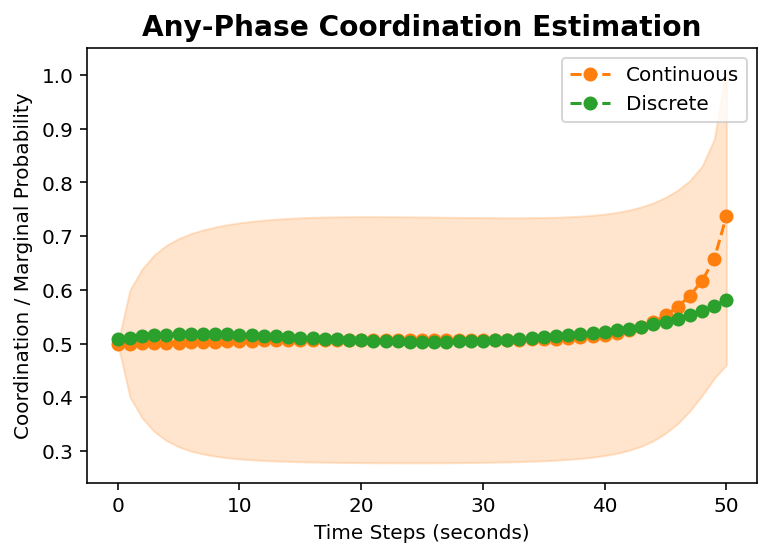

In [81]:
discrete_inference_engine = get_discrete_inference_engine(series_a, series_b, ANYPHASE_FUNCTION)
continuous_inference_engine = get_continuous_inference_engine(series_a, series_b, ANYPHASE_FUNCTION)

marginal_cs = discrete_inference_engine.estimate_marginals()[1]
params = continuous_inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(6, 4))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--", label="Continuous")
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:green", linestyle="--", label="Discrete")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination / Marginal Probability")
plt.title("Any-Phase Coordination Estimation", fontsize=14, weight="bold")
plt.legend()

### Flipped Alignment

For the series of toy vocalics below, both anti-phase and any-phase have the same alignment and should result in the same coordination estimates over time.

Text(0.5, 1.0, 'Toy Feature')

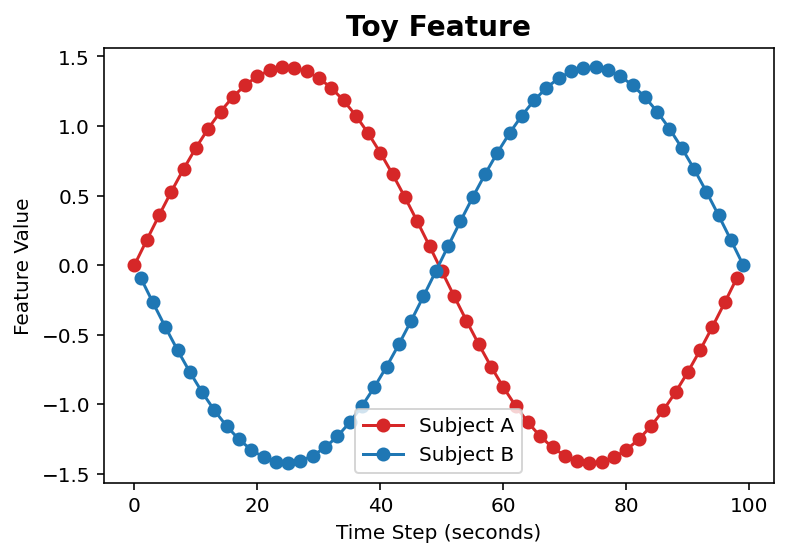

In [83]:
series_a = SparseSeries(xs, mask_a)
series_b = SparseSeries(1 - xs, mask_b)
series_a.normalize()
series_b.normalize()

fig = plt.figure(figsize=(6,4))
plot_vocalic_features([fig.gca()], series_a, series_b, feature_names=[""])
plt.ylabel("Feature Value")
plt.title("Toy Feature", fontsize=14, weight="bold")

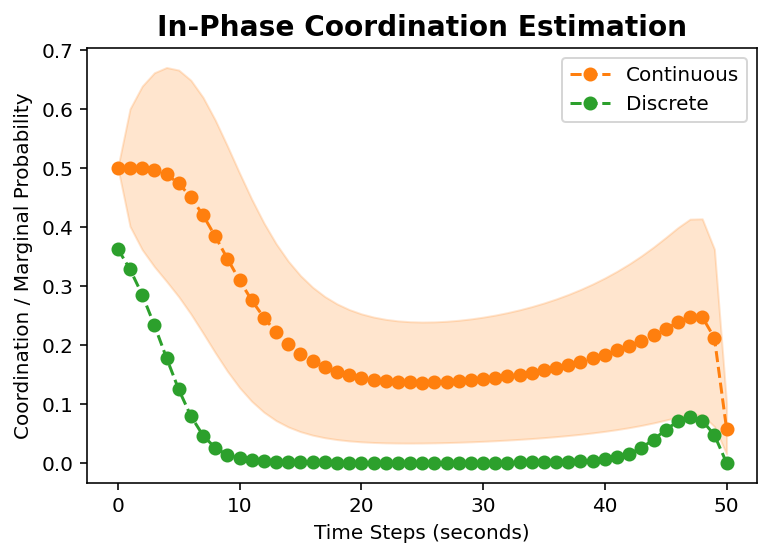

In [87]:
discrete_inference_engine = get_discrete_inference_engine(series_a, series_b)
continuous_inference_engine = get_continuous_inference_engine(series_a, series_b)

marginal_cs = discrete_inference_engine.estimate_marginals()[1]
params = continuous_inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(6, 4))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--", label="Continuous")
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:green", linestyle="--", label="Discrete")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination / Marginal Probability")
plt.title("In-Phase Coordination Estimation", fontsize=14, weight="bold")
plt.legend()

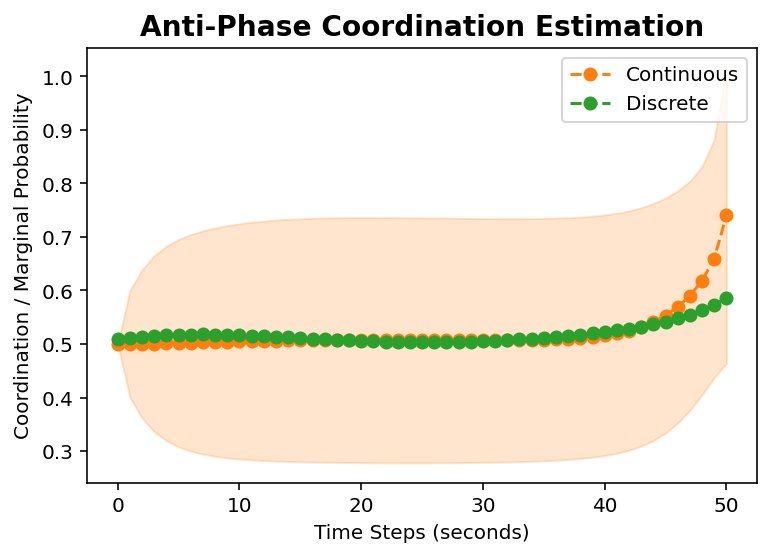

In [85]:
discrete_inference_engine = get_discrete_inference_engine(series_a, series_b, ANTIPHASE_FUNCTION)
continuous_inference_engine = get_continuous_inference_engine(series_a, series_b, ANTIPHASE_FUNCTION)

marginal_cs = discrete_inference_engine.estimate_marginals()[1]
params = continuous_inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(6, 4))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--", label="Continuous")
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:green", linestyle="--", label="Discrete")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination / Marginal Probability")
plt.title("Anti-Phase Coordination Estimation", fontsize=14, weight="bold")
plt.legend()

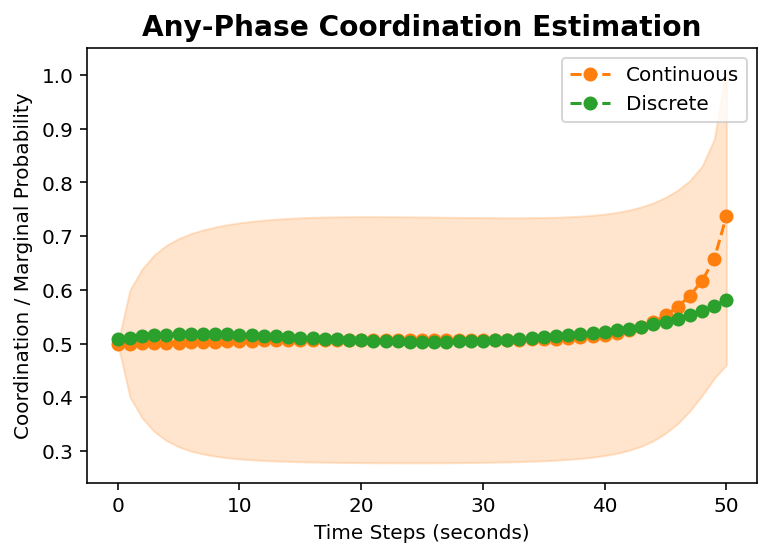

In [86]:
discrete_inference_engine = get_discrete_inference_engine(series_a, series_b, ANYPHASE_FUNCTION)
continuous_inference_engine = get_continuous_inference_engine(series_a, series_b, ANYPHASE_FUNCTION)

marginal_cs = discrete_inference_engine.estimate_marginals()[1]
params = continuous_inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(6, 4))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--", label="Continuous")
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:green", linestyle="--", label="Discrete")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination / Marginal Probability")
plt.title("Any-Phase Coordination Estimation", fontsize=14, weight="bold")
plt.legend()

### Shifted Alignment

For the series of toy vocalics below, both phase, any-phase do not change the alignment and should result in the same coordination estimates over time.

Text(0.5, 1.0, 'Toy Feature')

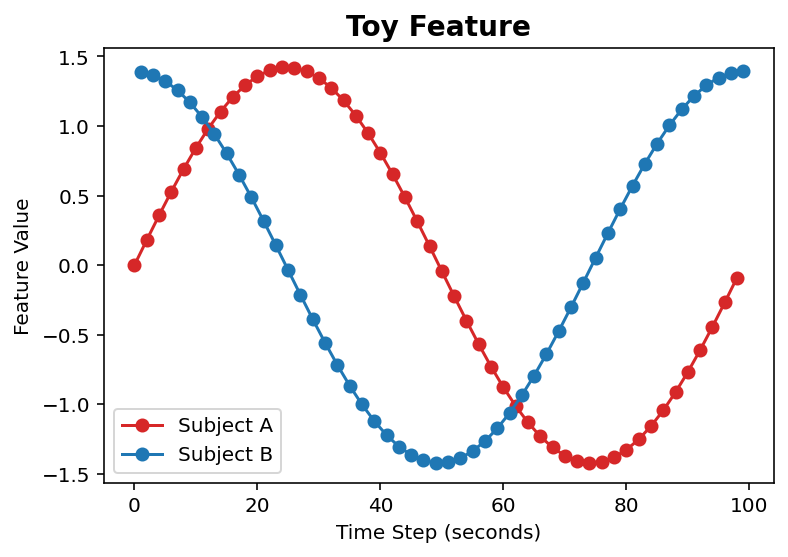

In [88]:
series_a = SparseSeries(xs, mask_a)
series_b = SparseSeries(np.sin(np.linspace(np.pi/2,2*np.pi + np.pi/2,NUM_TIME_STEPS)), mask_b)
series_a.normalize()
series_b.normalize()

fig = plt.figure(figsize=(6,4))
plot_vocalic_features([fig.gca()], series_a, series_b, feature_names=[""])
plt.ylabel("Feature Value")
plt.title("Toy Feature", fontsize=14, weight="bold")

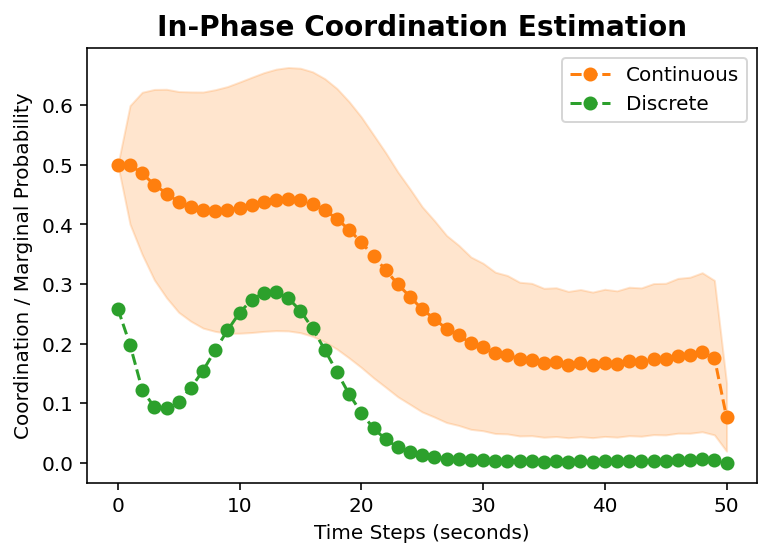

In [93]:
discrete_inference_engine = get_discrete_inference_engine(series_a, series_b)
continuous_inference_engine = get_continuous_inference_engine(series_a, series_b)

marginal_cs = discrete_inference_engine.estimate_marginals()[1]
params = continuous_inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(6, 4))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--", label="Continuous")
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:green", linestyle="--", label="Discrete")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination / Marginal Probability")
plt.title("In-Phase Coordination Estimation", fontsize=14, weight="bold")
plt.legend()

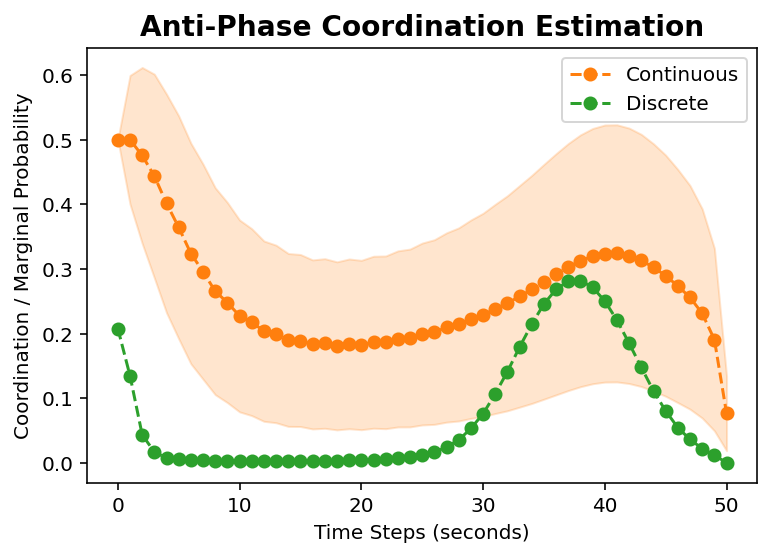

In [92]:
discrete_inference_engine = get_discrete_inference_engine(series_a, series_b, ANTIPHASE_FUNCTION)
continuous_inference_engine = get_continuous_inference_engine(series_a, series_b, ANTIPHASE_FUNCTION)

marginal_cs = discrete_inference_engine.estimate_marginals()[1]
params = continuous_inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(6, 4))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--", label="Continuous")
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:green", linestyle="--", label="Discrete")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination / Marginal Probability")
plt.title("Anti-Phase Coordination Estimation", fontsize=14, weight="bold")
plt.legend()

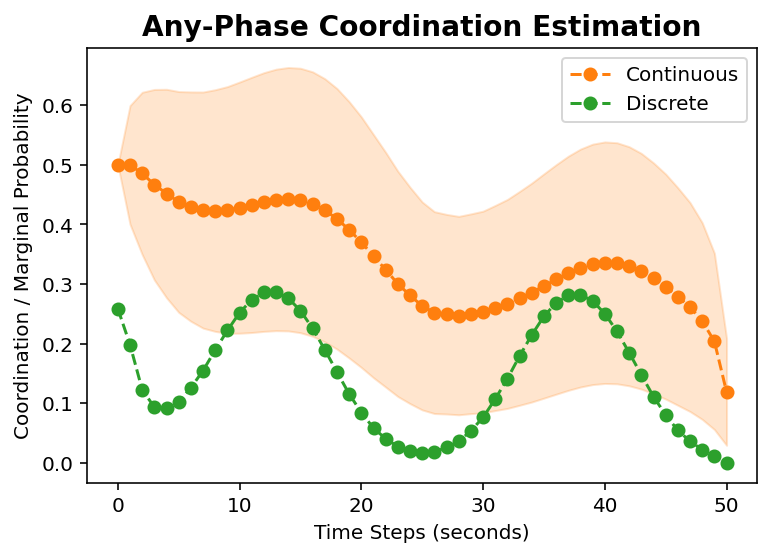

In [91]:
discrete_inference_engine = get_discrete_inference_engine(series_a, series_b, ANYPHASE_FUNCTION)
continuous_inference_engine = get_continuous_inference_engine(series_a, series_b, ANYPHASE_FUNCTION)

marginal_cs = discrete_inference_engine.estimate_marginals()[1]
params = continuous_inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(6, 4))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--", label="Continuous")
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:green", linestyle="--", label="Discrete")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination / Marginal Probability")
plt.title("Any-Phase Coordination Estimation", fontsize=14, weight="bold")
plt.legend()